# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data?resource=download . Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [40]:
# Import the necessary packages

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [23]:
# Import the dataset

fraud_df = pd.read_csv('../archive/Fraud.csv')

In [24]:
fraud_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#### Descriptive statistics

In [25]:
# Create a subset of the main dataset with with n=100000 elements

fraud_df_sub = fraud_df.sample(n=100000)

In [26]:
# We take a look at the dataset

fraud_df_sub.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
4550935,327,CASH_IN,332202.57,C2057100782,1555910.91,1888113.48,C244985965,568590.24,236387.67,0,0
5929720,404,CASH_IN,185879.98,C297686471,117097.00,302976.98,C540561492,278196.13,92316.15,0,0
4080434,301,CASH_OUT,353446.52,C365829620,30492.00,0.00,C1119483946,0.00,353446.52,0,0
3331020,253,CASH_IN,112315.17,C1350320277,359791.29,472106.46,C1519560817,17530454.16,17418138.99,0,0
1758546,161,CASH_IN,78351.90,C2043168569,36021.00,114372.90,C1538416750,635570.34,557218.44,0,0


In [27]:
# Types of data and missing values
fraud_df_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 4550935 to 4770029
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            100000 non-null  int64  
 1   type            100000 non-null  object 
 2   amount          100000 non-null  float64
 3   nameOrig        100000 non-null  object 
 4   oldbalanceOrg   100000 non-null  float64
 5   newbalanceOrig  100000 non-null  float64
 6   nameDest        100000 non-null  object 
 7   oldbalanceDest  100000 non-null  float64
 8   newbalanceDest  100000 non-null  float64
 9   isFraud         100000 non-null  int64  
 10  isFlaggedFraud  100000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 9.2+ MB


In [28]:
fraud_df_sub.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,100000.000000,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000,100000.0
mean,243.505830,1.796234e+05,8.252694e+05,8.463321e+05,1.105329e+06,1.228817e+06,0.001220,0.0
std,142.376481,5.756899e+05,2.871893e+06,2.908629e+06,3.290275e+06,3.550786e+06,0.034907,0.0
min,1.000000,2.600000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,155.000000,1.350071e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,239.000000,7.485853e+04,1.444592e+04,0.000000e+00,1.301359e+05,2.123904e+05,0.000000,0.0
75%,335.000000,2.085333e+05,1.072005e+05,1.428805e+05,9.516573e+05,1.123120e+06,0.000000,0.0
max,742.000000,4.475755e+07,3.816670e+07,3.825960e+07,2.519574e+08,2.523586e+08,1.000000,0.0


### What is the distribution of the outcome? 

In [29]:
# Distribution of the outcome isFraud
fraud_df['isFraud'].value_counts()/len(fraud_df)

# We clearly have an unbalanced distribution of the outcome


0    0.998709
1    0.001291
Name: isFraud, dtype: float64

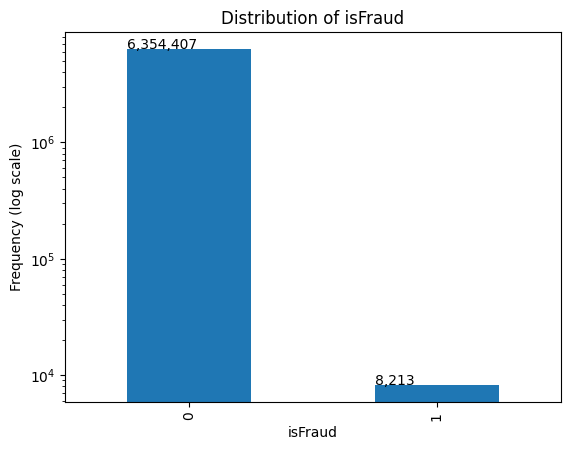

In [30]:
axes = pd.value_counts(fraud_df['isFraud'], sort = True).sort_index().plot(kind = 'bar', title = 'Distribution of isFraud')

for p in axes.patches:
    axes.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))
    plt.xlabel('isFraud')
    plt.ylabel('Frequency (log scale)')
    plt.yscale('log')
plt.show()

### Clean the dataset. Pre-process it to make it suitable for ML training. Feel free to explore, drop, encode, transform, etc. Whatever you feel will improve the model score.

In [31]:
# Check for duplicates
duplicates = fraud_df.duplicated()

# Display rows that are duplicates
duplicate_rows = fraud_df[duplicates]
print("Duplicate rows:")
print(duplicate_rows)

# We have no duplicates in the dataset

Duplicate rows:
Empty DataFrame
Columns: [step, type, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, isFraud, isFlaggedFraud]
Index: []


In order to make the dataset suitable for ML training, we will do the following changes:
- One Hot Enconding
- Create a Training/Test dataset
- Data Normalization or Scaling


In [52]:
# We will do one hot transform to the variable type

fraud_df_enc = pd.get_dummies(fraud_df, columns = ['type'], drop_first=True) 

In [53]:
X = fraud_df_enc.drop(columns=['isFraud','nameDest','nameOrig'])
y = fraud_df_enc['isFraud']

In [54]:
# We will create a training and test dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

In [51]:
# We will normalize the data

normalizer = MinMaxScaler()
normalizer = normalizer.fit(X_train)
X_train_normalized = normalizer.transform(X_train)
X_test_normalized = normalizer.transform(X_test)

### Run a logisitc regression classifier and evaluate its accuracy.

In [57]:
from sklearn.linear_model import LogisticRegression

# initialize the model
model = LogisticRegression()

# training the model on the training datasets
model = model.fit(X_train, y_train)

# We calculate predictions
y_pred = model.predict(X_test)

from sklearn.metrics import accuracy_score
print("The accuracy of the model on the test data is:", accuracy_score(y_test, y_pred))

The accuracy of the model on the test data is: 0.9983128019589415


### Now pick a model of your choice and evaluate its accuracy.

In [58]:
# We will try with a KNN

from sklearn.neighbors import KNeighborsClassifier

# initialize the model
model = KNeighborsClassifier(n_neighbors = 3)

# training your model on the training datasets
model = model.fit(X_train, y_train)

# We calculate predictions
y_pred = model.predict(X_test)

print("The accuracy of the model on the test data is:", accuracy_score(y_test, y_pred))

The accuracy of the model on the test data is: 0.999451483822702


### Which model worked better and how do you know?

In [ ]:
"""
Based on their accuracy scores, both model seem to perform extremely well - the diffence in terms of accuracy scores between the two is negligible.
Given the inbalanced dataset, both models are getting the prediction right cause the great majority of them in the dataset are not fraud anyway.
"""

### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.